>>Leading Libraries

In [26]:
%pip install sklearn 
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import re
from functools import partial
from scipy.stats import mode

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PolynomialFeatures
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.kernel_approximation import Nystroem
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

%pip install optuna
import optuna

np.set_printoptions(linewidth=195, edgeitems=5)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


>>Data Load
- original dataset 미포함

In [6]:
train_df=pd.read_csv('/Users/ibeub/Desktop/data/train.csv')
test_df=pd.read_csv('/Users/ibeub/Desktop/data/test.csv')
submission_df=pd.read_csv('/Users/ibeub/Desktop/data/sample_submission.csv')

train_df.drop(columns=["id"],inplace=True)
test_df.drop(columns=["id"],inplace=True)

>>데이터 요약

In [10]:
def resume_table(df):
    # df = df.drop(columns=target_name)
    summary_df = df.dtypes
    df = df * 1 # defects를 int형으로 바꾸기
    summary_df = summary_df.reset_index()
    summary_df.columns = ['Column', 'Dtypes']
    summary_df['결측치'] = df.isnull().sum().values
    summary_df['유니크개수'] = df.nunique().values
    summary_df['평균'] = df.describe().loc['mean'].values
    summary_df['min'] = df.describe().loc['min'].values
    summary_df['median'] = df.describe().loc['50%'].values
    summary_df['max'] = df.describe().loc['max'].values
    return summary_df.set_index('Column')

resume_table(train_df)

,Dtypes,결측치,유니크개수,평균,min,median,max
Column,,,,,,,
loc,float64,0,378,37.347160,1.0,22.00,3442.00
v(g),float64,0,106,5.492684,1.0,3.00,404.00
ev(g),float64,0,71,2.845022,1.0,1.00,165.00
iv(g),float64,0,84,3.498826,1.0,2.00,402.00
n,float64,0,836,96.655995,0.0,51.00,8441.00
v,float64,0,4515,538.280956,0.0,232.79,80843.08
l,float64,0,55,0.111634,0.0,0.09,1.00
d,float64,0,3360,13.681881,0.0,9.82,418.20
i,float64,0,5171,27.573007,0.0,23.36,569.78


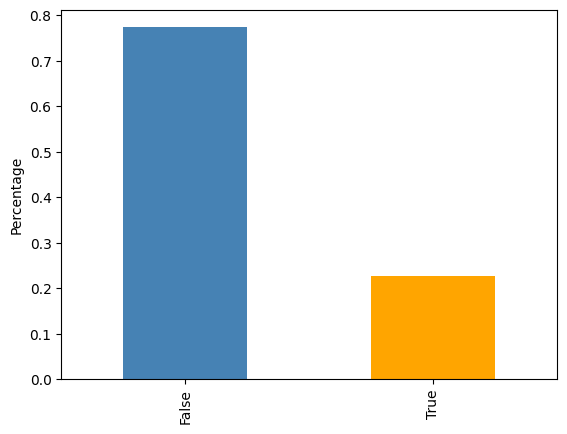

In [31]:
#visualizing defects
train = pd.read_csv('/Users/ibeub/Desktop/data/train.csv')
train['defects'].value_counts(normalize = True).plot(kind = 'bar', color = ['steelblue', 'orange'])
plt.ylabel('Percentage');

>>결과해석: 막대 그래프에서 데이터가 불균형하다는 것을 확인할 수 있음 (~77% False 및 ~23% True).

>>EDA

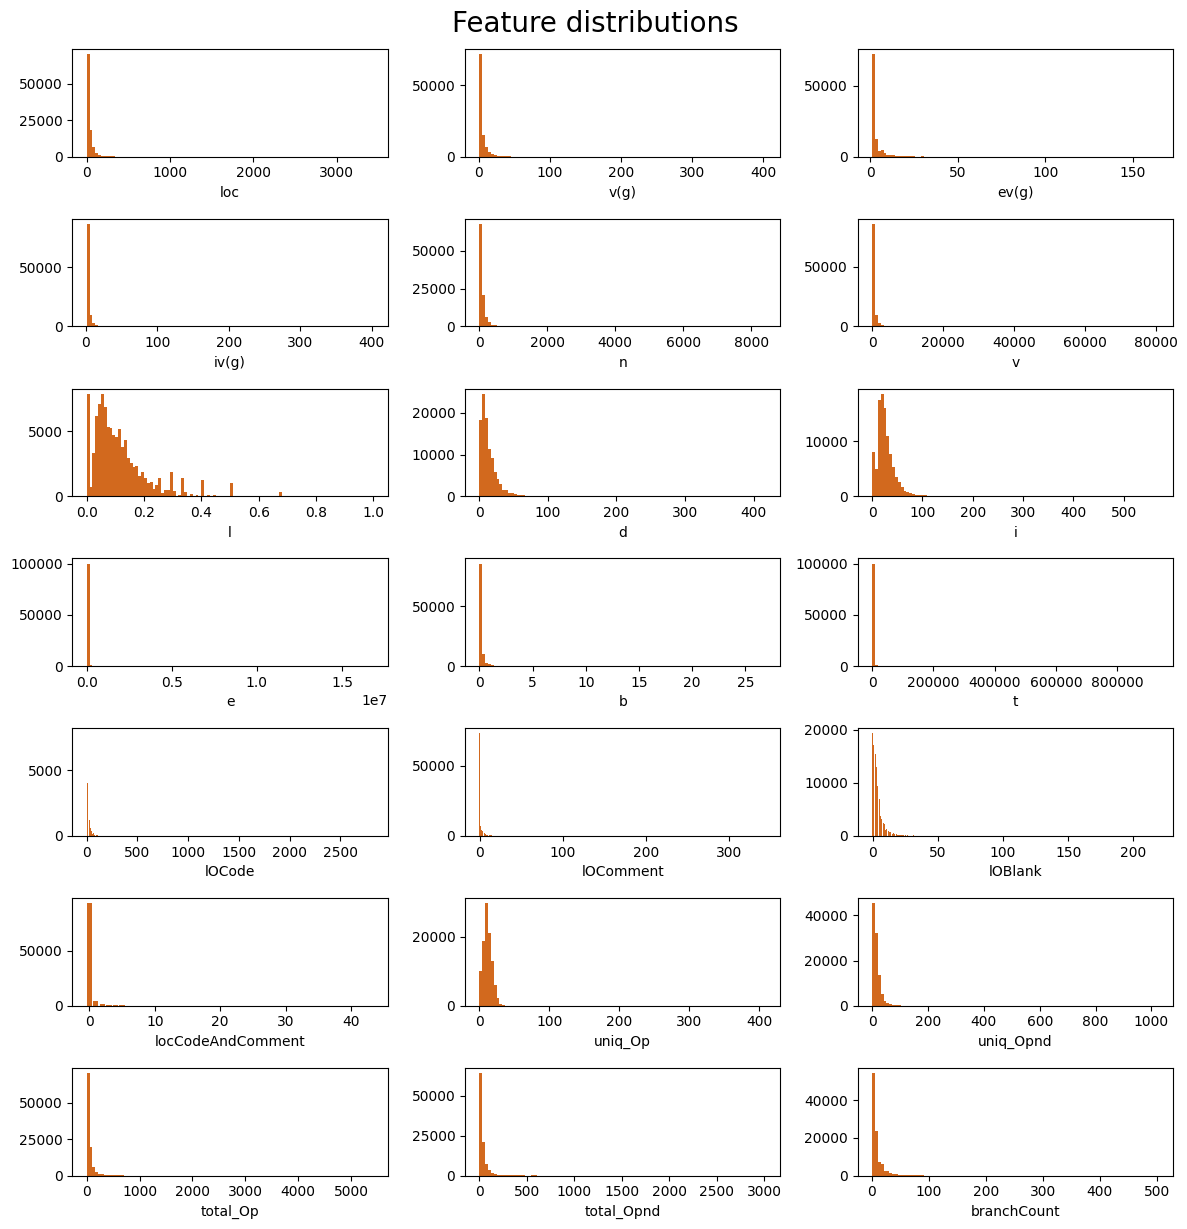

In [11]:
# 데이터의 분포 확인 (히스토그램)

_, axs = plt.subplots(7, 3, figsize=(12, 12))
for col, ax in zip(test_df.columns, axs.ravel()):
    if train_df[col].dtype == float:
        ax.hist(train_df[col], bins=100, color='chocolate')
    else: #int
        vc = train_df[col].value_counts()
        ax.bar(vc.index, vc, color='chocolate')
    ax.set_xlabel(col)
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

# 결과해석: 21개의 feature 모두 양수이고 분포는 right-skewed되어 있음 -> log 변환 필요

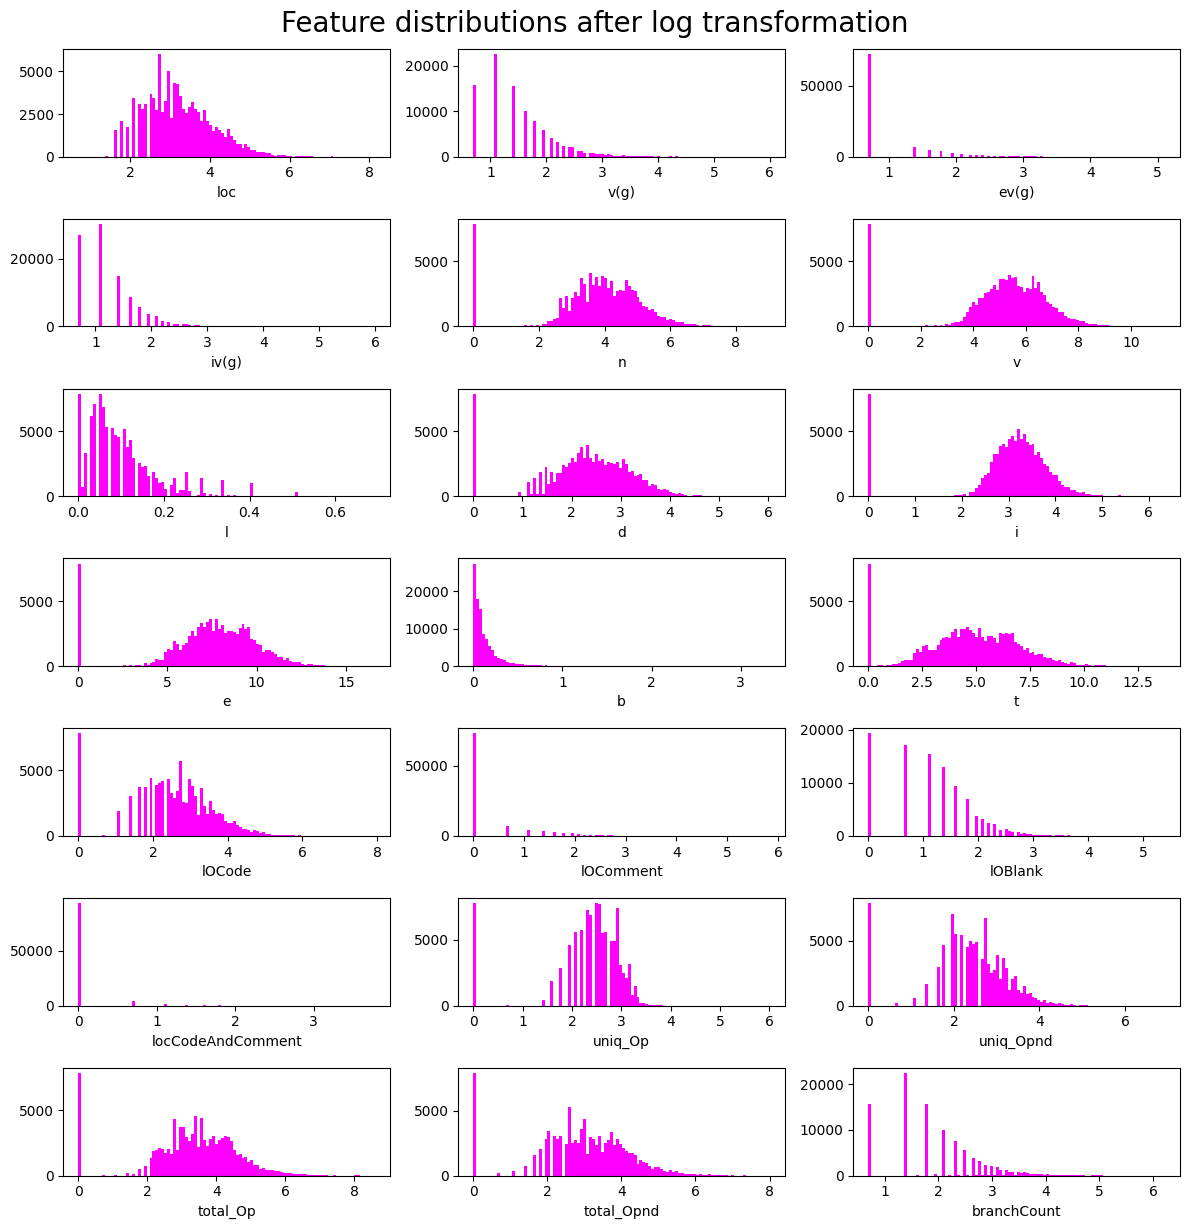

In [12]:
# log transformation(로그 함수 적용)을 통해 데이터의 분포 확인 (히스토그램)
_, axs = plt.subplots(7, 3, figsize=(12, 12))
for col, ax in zip(test_df.columns, axs.ravel()):
    ax.hist(np.log1p(train_df[col]), bins=100, color='magenta')
    ax.set_xlabel(col)
plt.tight_layout()
plt.suptitle('Feature distributions after log transformation', y=1.02, fontsize=20)
plt.show()

# 결과해석: log transformation을 통해 데이터의 분포가 정규분포에 가까워짐

In [13]:
# 데이터의 상관관계 확인

corr = train_df.corr().round(2)
corr.style.background_gradient(cmap='coolwarm').format("{:.2f}")

# 결과해석: 상관관계가 높은 feature들이 존재 -> feature selection 필요
# 추후 고려할 방법: 상관관계가 높은 feature들 중 하나만 선택하거나, PCA를 통해 차원 축소를 진행할 수 있음

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,b,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
loc,1.00,0.76,0.54,0.70,0.76,0.76,-0.39,0.60,0.49,0.50,0.74,0.51,0.80,0.53,0.67,0.25,0.37,0.64,0.76,0.76,0.76,0.34
v(g),0.76,1.00,0.73,0.79,0.63,0.62,-0.39,0.57,0.30,0.43,0.61,0.47,0.64,0.38,0.46,0.21,0.39,0.53,0.64,0.61,0.97,0.30
ev(g),0.54,0.73,1.00,0.55,0.39,0.37,-0.33,0.36,0.16,0.28,0.36,0.28,0.38,0.29,0.28,0.16,0.20,0.28,0.39,0.37,0.77,0.26
iv(g),0.70,0.79,0.55,1.00,0.59,0.59,-0.29,0.49,0.32,0.39,0.56,0.41,0.64,0.34,0.43,0.18,0.38,0.55,0.59,0.57,0.75,0.25
n,0.76,0.63,0.39,0.59,1.00,0.93,-0.30,0.81,0.73,0.57,0.92,0.60,0.91,0.57,0.78,0.26,0.62,0.82,0.96,0.95,0.63,0.26
v,0.76,0.62,0.37,0.59,0.93,1.00,-0.25,0.75,0.67,0.58,0.94,0.59,0.90,0.53,0.74,0.24,0.54,0.80,0.94,0.94,0.61,0.23
l,-0.39,-0.39,-0.33,-0.29,-0.30,-0.25,1.00,-0.43,-0.16,-0.09,-0.25,-0.10,-0.29,-0.19,-0.29,-0.13,-0.40,-0.28,-0.29,-0.29,-0.42,-0.25
d,0.60,0.57,0.36,0.49,0.81,0.75,-0.43,1.00,0.52,0.47,0.76,0.49,0.78,0.49,0.68,0.27,0.78,0.69,0.81,0.78,0.58,0.24
i,0.49,0.30,0.16,0.32,0.73,0.67,-0.16,0.52,1.00,0.29,0.68,0.30,0.68,0.44,0.65,0.21,0.53,0.80,0.70,0.74,0.31,0.21
e,0.50,0.43,0.28,0.39,0.57,0.58,-0.09,0.47,0.29,1.00,0.61,0.80,0.58,0.33,0.44,0.12,0.28,0.41,0.58,0.57,0.43,0.10


In [18]:
# 높은 상관관계만 확인

corr = train_df.corr().round(2)
corr_abs = corr.abs().stack().sort_values(ascending=False)
corr_abs[corr_abs != 1][:10]

#결과해석: 상관관계가 높은(0.9기준) feature들이 존재 -> feature selection 필요

branchCount  v(g)           0.97
v(g)         branchCount    0.97
total_Op     total_Opnd     0.96
total_Opnd   total_Op       0.96
total_Op     n              0.96
n            total_Op       0.96
total_Opnd   n              0.95
n            total_Opnd     0.95
b            v              0.94
total_Opnd   v              0.94
dtype: float64

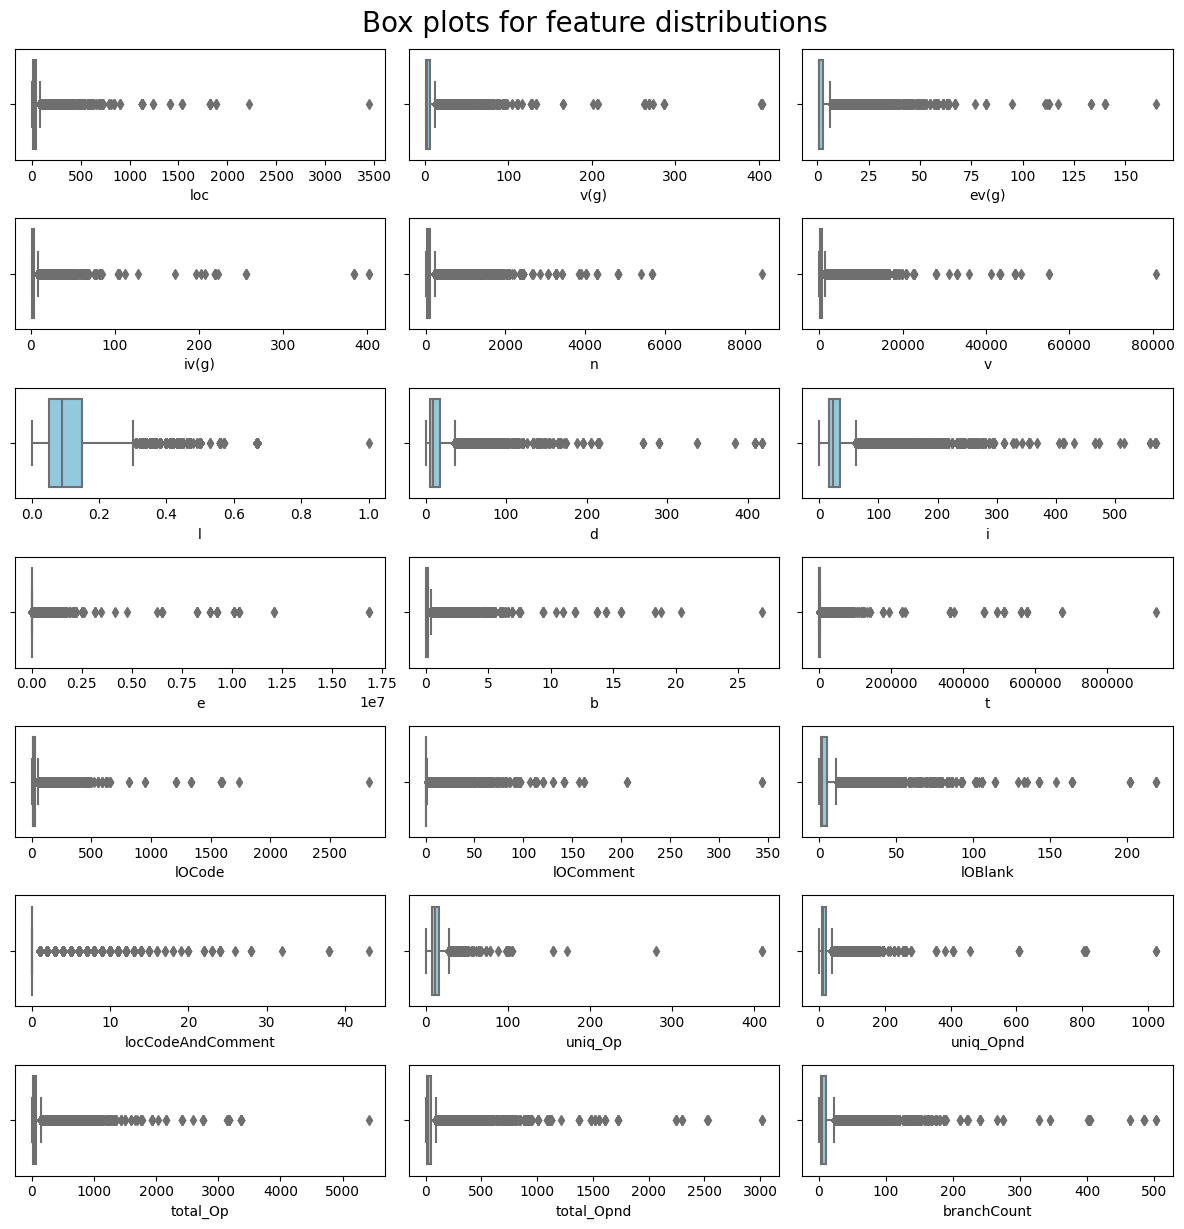

In [20]:
# 박스 플롯을 통해 이상치 확인
import seaborn as sns

_, axs = plt.subplots(7, 3, figsize=(12, 12))
for col, ax in zip(test_df.columns, axs.ravel()):
    sns.boxplot(x=train_df[col], ax=ax, color='skyblue')
    ax.set_xlabel(col)
plt.tight_layout()
plt.suptitle('Box plots for feature distributions', y=1.02, fontsize=20)
plt.show()

# 결과해석: 이상치가 존재 -> 이상치 제거 여부 및 방법 고려 필요

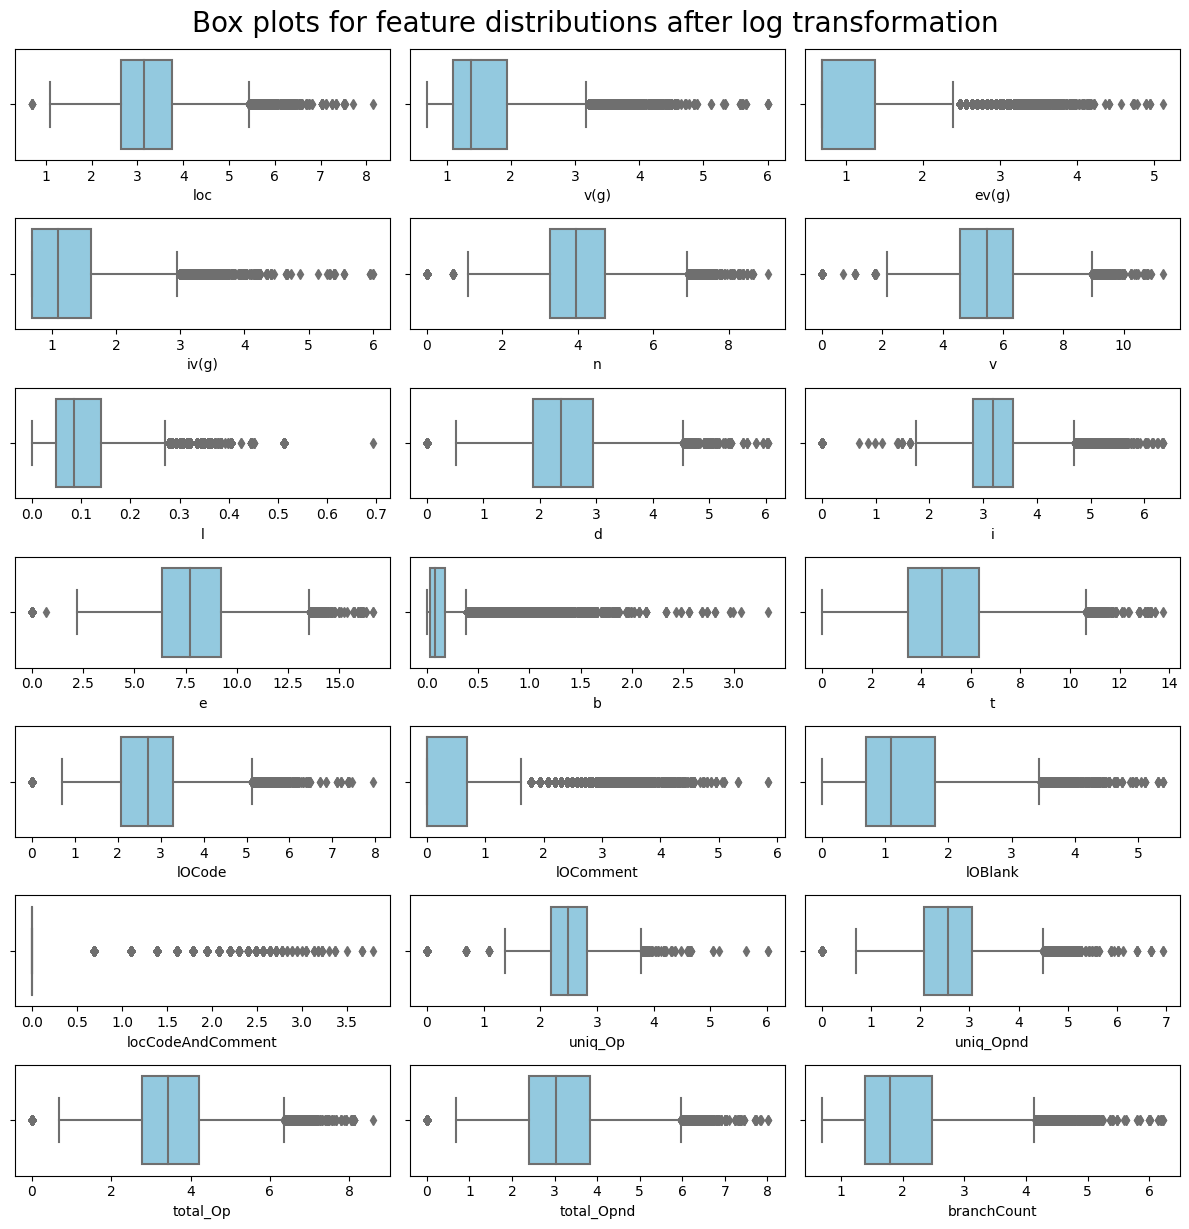

In [21]:
# (log transformationed data) 박스 플롯을 통해 이상치 확인

_, axs = plt.subplots(7, 3, figsize=(12, 12))
for col, ax in zip(test_df.columns, axs.ravel()):
    sns.boxplot(x=np.log1p(train_df[col]), ax=ax, color='skyblue')
    ax.set_xlabel(col)
plt.tight_layout()
plt.suptitle('Box plots for feature distributions after log transformation', y=1.02, fontsize=20)
plt.show()

# 결과해석: log transformation을 통해 이상치가 줄어듦 -> 모델 성능 향상에 도움이 될 것으로 예상

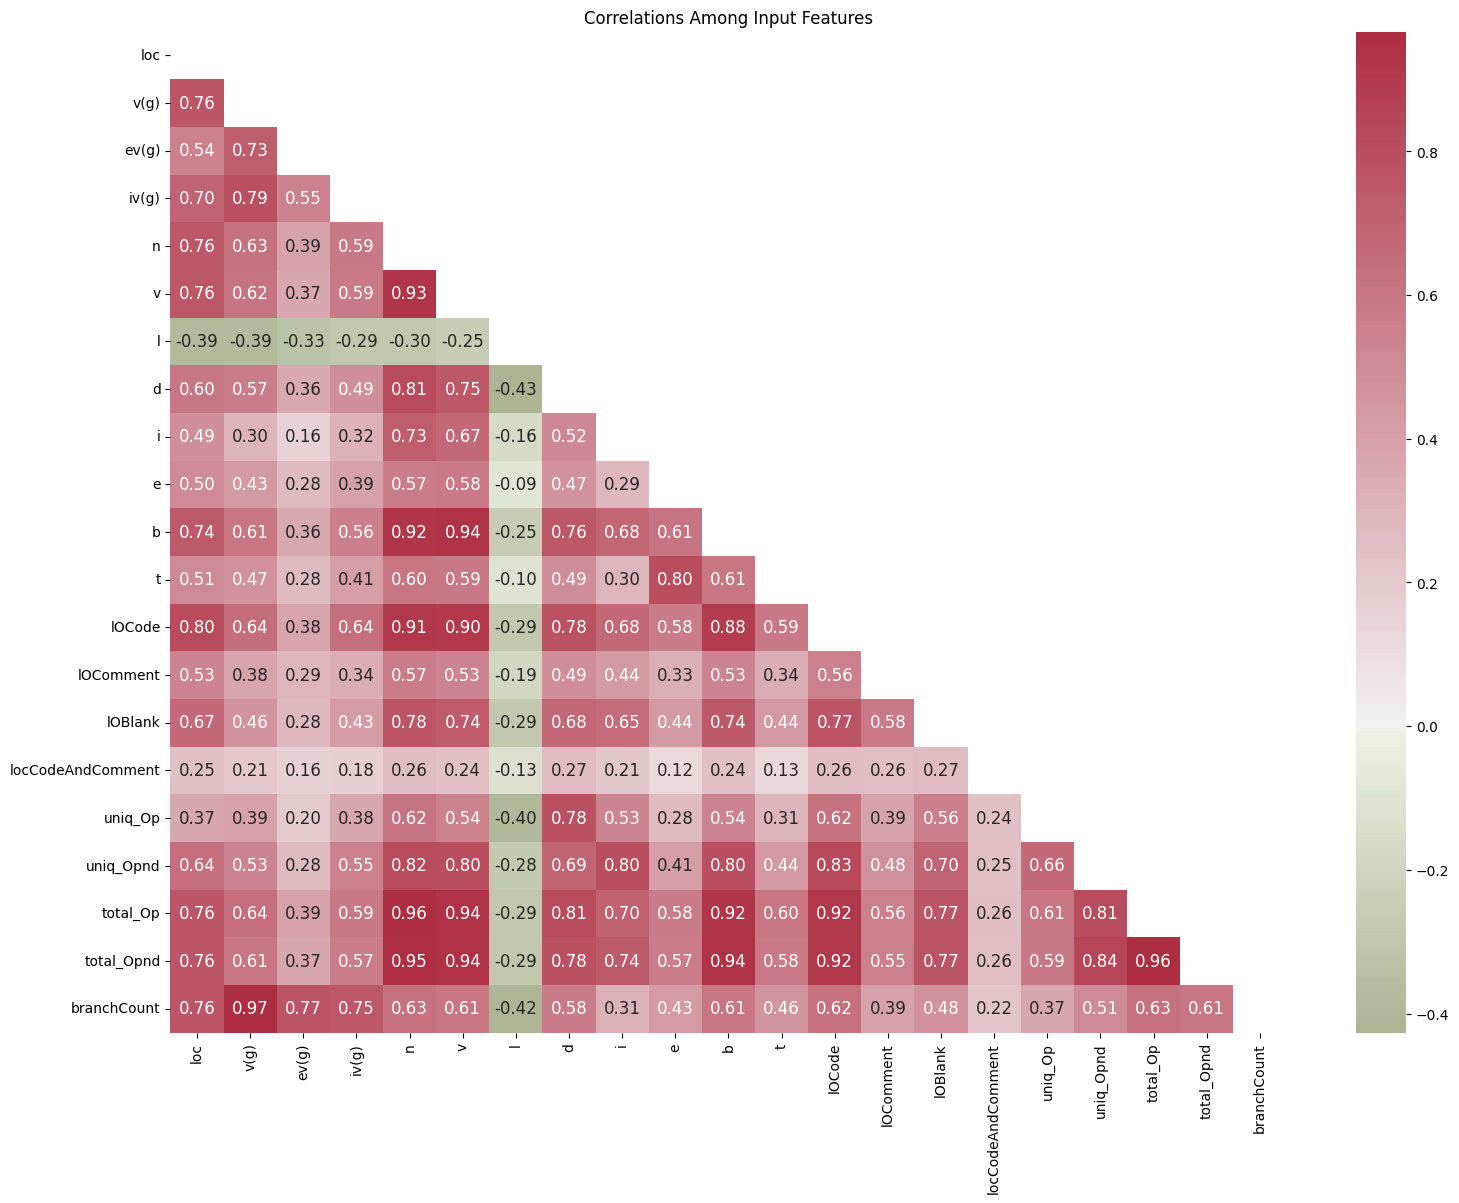

In [33]:
# 상관관계 히트맵
corr_mat = train.drop(columns = ['id', 'defects'], axis = 1).corr()

data_mask = np.triu(np.ones_like(corr_mat, dtype = bool))
cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 20, center = 'light', as_cmap = True)
f, ax = plt.subplots(figsize = (18, 13))
sns.heatmap(corr_mat, annot = True, cmap = cmap, fmt = '.2f', center = 0,
            annot_kws = {'size': 12}, mask = data_mask).set_title('Correlations Among Input Features');

>>결과해석: 
- branchCount와 v(g) 사이에는 97%의 상관관계가 있음
- total_Opnd와 total_Op 사이에는 96%의 상관관계가 있음
- total_Op와 n 사이에는 96%의 상관관계가 있음
- l은 다른 특징들과 음의 상관관계를 가진 유일한 특징임
- 상관 관계 히트맵을 기반으로, PCA를 통한 차원 축소 진행 검토
- 모든 입력 feature들이 오른쪽으로 치우쳐져 있기 때문에 PCA를 적용하기 전에 로그 변환 진행

In [37]:
#log 변환 후 PCA 적용
colnames = train.drop(columns = ['id', 'defects'], axis = 1).columns.tolist()

pca_md = Pipeline([('log-tran', ColumnTransformer([('log', FunctionTransformer(np.log1p), colnames)])), 
                   ('stand', StandardScaler()), 
                   ('pca', PCA())]).fit(train[colnames])

pca_md

Pipeline(steps=[('log-tran',
                 ColumnTransformer(transformers=[('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  ['loc', 'v(g)', 'ev(g)',
                                                   'iv(g)', 'n', 'v', 'l', 'd',
                                                   'i', 'e', 'b', 't', 'lOCode',
                                                   'lOComment', 'lOBlank',
                                                   'locCodeAndComment',
                                                   'uniq_Op', 'uniq_Opnd',
                                                   'total_Op', 'total_Opnd',
                                                   'branchCount'])])),
                ('stand', StandardScaler()), ('pca', PCA())])

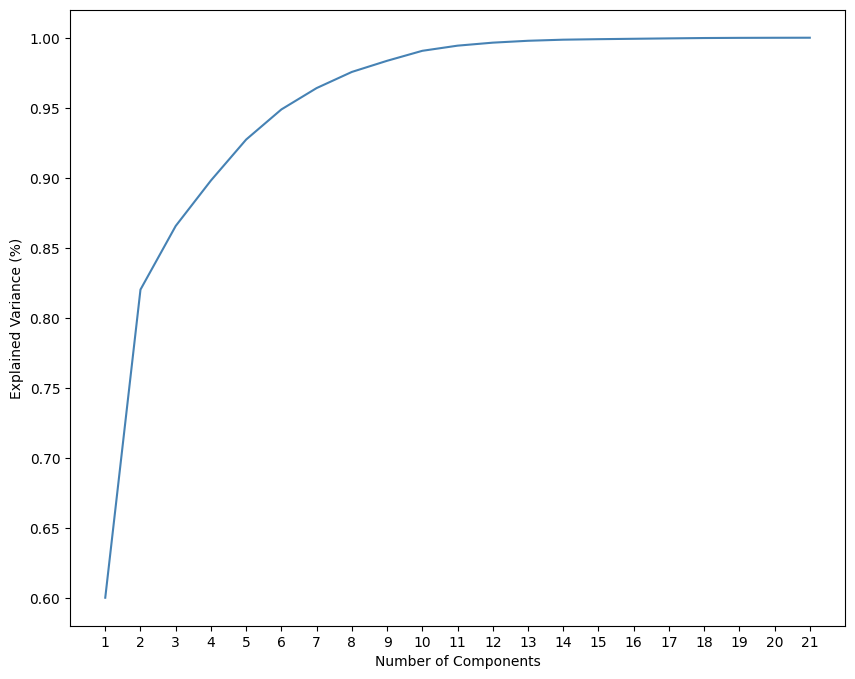

In [38]:
#PCA lineplot visualization
plt.figure(figsize = (10, 8))
ax = sns.lineplot(x = [i for i in range(1, 22)], y = np.cumsum(pca_md['pca'].explained_variance_ratio_), color = 'steelblue', markers = True);
ax.set_xlabel('Number of Components')
ax.set_ylabel('Explained Variance (%)')
ax.set_xticks([i for i in range(1, 22)]);

>>결과해석: PCA 진행결과, 첫 10개의 구성요소가 데이터의 변동성의 99% 이상을 설명한다는 것을 확인할 수 있음. 다음으로, 활용할 패턴이 있는지 확인하기 위해 구성요소 시각화

c:\Python39\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


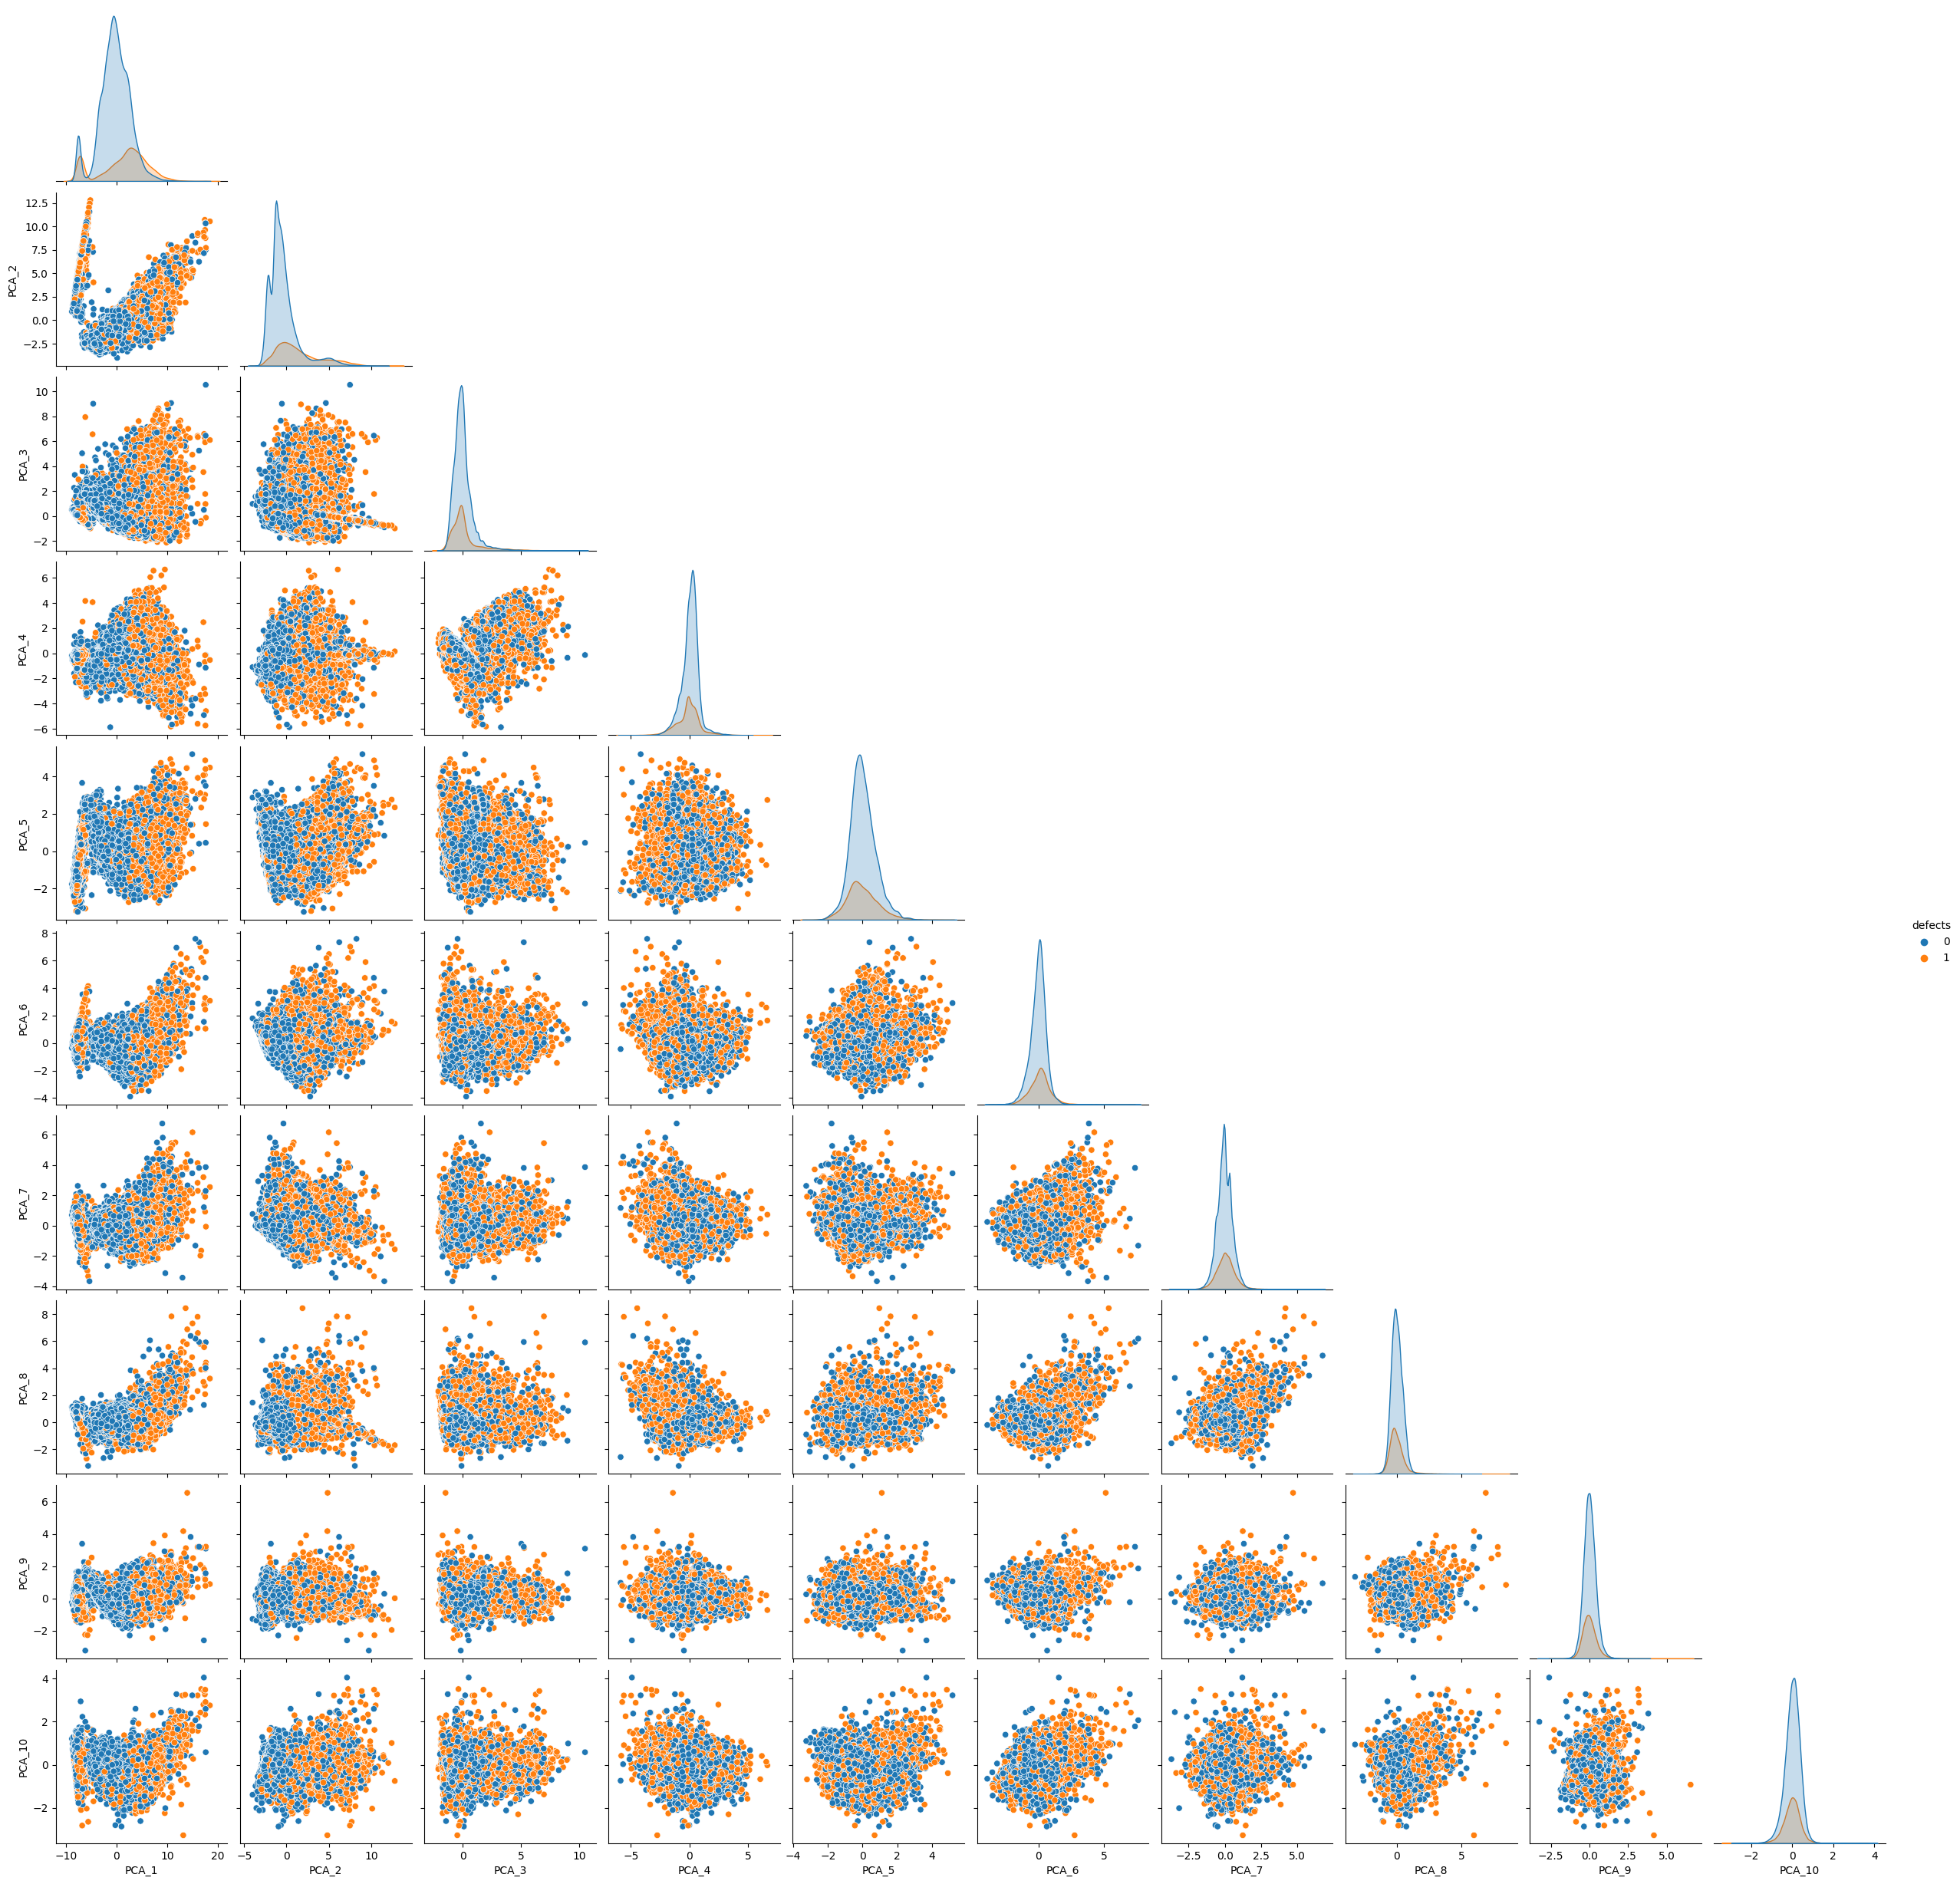

In [39]:
#PCA pair-plot으로 pipeline 구성
pca_10 = Pipeline([('log-tran', ColumnTransformer([('log', FunctionTransformer(np.log1p), colnames)])), 
                   ('stand', StandardScaler()), 
                   ('pca', PCA(n_components = 10))]).fit_transform(train[colnames])

pca_10 = pd.DataFrame(pca_10, columns = [str('PCA_') + str(i) for i in range(1, 11)])
pca_10['defects'] = train['defects'].map({False: 0, True: 1})

sns.pairplot(data = pca_10, hue = 'defects', corner = True);

>>결과해석: 위의 PCA pair-plot에서 다음과 같은 관찰 결과를 확인함:
- 두 클래스는 선형으로 구분될 수 없음.
- 일부 샘플들은 예측하기 어려움 (결함 = False). 예를 들어, PCA_1과 PCA_2 살펴보면 왼쪽 하단 모서리에는 파란색 샘플들 (결함 = True)이 있는데, 그 영역 대부분의 샘플들은 빨간색 (결함 = False)임.
- 다음으로, k-means 알고리즘을 실행하여 활용할 수 있는 패턴이 있는지 확인

In [ ]:
inertias = list()

for i in tqdm(range(2, 21)):

    kmeans_md = Pipeline([('log-tran', ColumnTransformer([('log', FunctionTransformer(np.log1p), colnames)])), 
                          ('stand', StandardScaler()), 
                          ('kmeans', KMeans(n_clusters = i, n_init = 20, random_state = 42))]).fit(train[colnames])

    inertias.append(kmeans_md['kmeans'].inertia_)
    
sns.lineplot(x = [i for i in range(2, 21)], y = inertias, color = 'steelblue')
plt.xlabel('Number of Clusters')
plt.ylabel('Cluster Inertia');